## Import libraries and data

In [1]:
# Import libraries

import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt


# Load data
path = r'data'
allFiles = glob.glob(path + "/*.csv")
frame = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_, index_col = None, header = 1)
    list_.append(df)
frame = pd.concat(list_)



/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0,19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0,112) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0,123,124,125,128,129,130,133,139,140,141) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=comp

## Clean data and add useful variables

In [78]:
# Change interest rate to float
frame['int_rate_num'] = frame['int_rate'].str.rstrip('%').astype('float') / 100.0

# Cast emp_length to int
def emp_length_to_int(s):
    return max([int(n) for n in str(s).split() if n.isdigit()] + [0])
frame['emp_length_num'] = frame['emp_length'].apply(emp_length_to_int)

# Add late and default dummies
is_late_16_30 = lambda s: int(s == "Late (16-30 days)")
is_late_31_120 = lambda s: int(s == "Late (31-120 days)")
is_default = lambda s: int(s == "Default")
is_bad = lambda s: int(s == "Default" or s == 'Does not meet the credit policy. Status:Charged Off' or s == "Charged Off")

frame['late_16_30'] = frame.loan_status.apply(is_late_16_30)
frame['late_31_120'] = frame.loan_status.apply(is_late_31_120)
frame['default'] = frame.loan_status.apply(is_default)
frame['bad'] = frame.loan_status.apply(is_bad)

# Add interest-to-total-received and late-fees-to-total-received ratios
frame['int_to_total'] = frame['total_rec_int'] / frame['total_pymnt']
frame['late_fees_to_total'] = frame['total_rec_late_fee'] / frame['total_pymnt']

# Add returns
frame['return'] = frame.total_pymnt / frame.funded_amnt
frame['return2'] = (frame.total_pymnt / frame.funded_amnt) ** 2

# Add year issued
frame['issued_year'] = frame.issue_d.apply(lambda s: str(s)[-4:])

## Plot loan grade distributions

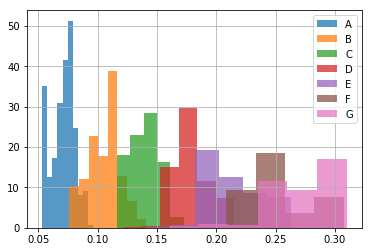

In [39]:
# Plot distribution of interest rates for each loan grade

for grade in ['A', 'B', 'C', 'D', 'E', 'F', 'G']:
    subset = frame['grade'] == grade
    frame['int_rate_num'][subset].hist(label = grade, normed = True, alpha = 0.75)

plt.legend()
plt.show()

# Plot distribution of interest rates for each loan subgrade

# for sub_grade in {sg for sg in set(frame['sub_grade']) if sg == sg}:
#     subset = frame['sub_grade'] == sub_grade
#     frame['int_rate_num'][subset].hist(label = sub_grade, normed = True, alpha = 0.75)

# plt.legend()
# plt.show()

## Add dummies, remove NAs, split into training and test

In [79]:
# Construct data frame of just pre-application characteristics

frame_completed = frame[frame.loan_status != 'Current']

post_variables = ["all_util", 
                "collection_recovery_fee", 
                "funded_amnt", "funded_amnt_inv", "grade", "id", "initial_list_status",
                "installment", "int_rate", "issue_d", "last_credit_pull_d", 
                "last_fico_range_high", "last_fico_range_low", "last_pymnt_amnt",
                "last_pymnt_d", "member_id", "next_pymnt_d", "out_prncp", 
                "out_prncp_inv", "pymnt_plan", "sub_grade", 
                "total_pymnt", "total_pymnt_inv", "total_rec_int", "total_rec_late_fee",
                "total_rec_prncp", "hardship_flag", "hardship_type", "hardship_reason",
                "hardship_status", "deferral_term", "hardship_amount",
                "hardship_start_date", "hardship_end_date", "payment_plan_start_date",
                "hardship_length", "hardship_dpd", "hardship_resaon", "hardship_loan_status",
                "earliest_cr_line", "id", "loan_status", "debt_settlement_flag", 
                "zip_code", "title", "desc", "url", "emp_length", "settlement_status",
                "emp_title", 'settlement_date', "debt_settlement_flag_date", 
                "sec_app_earliest_cr_line", "collection_recovery_fee", "revol_util",
                "late_16_30", "late_31_120", "default", "int_to_total", "late_fees_to_total"]
post_variables = list(set(post_variables).intersection(frame.columns))

pre_data = frame_completed.drop(post_variables, axis=1)
pre_data_dummies = pd.get_dummies(pre_data)

# Drop nas
pre_data_dummies_no_na = pre_data_dummies[pre_data_dummies.columns[pre_data_dummies.isnull().sum() < 100]].dropna()

In [80]:
# Split data into traning and test

from sklearn.model_selection import train_test_split

regressands = ['bad', 'return', 'return2', 'recoveries']
features = pre_data_dummies_no_na.drop(regressands, axis=1)
labels = pre_data_dummies_no_na[regressands]
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.8, 
                                                                            random_state = 42)

## Logistic Regression

In [92]:
# Logistic regression of probability of going bad on pre-application characteristics

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(train_features, train_labels["bad"])
test_features['pred_fail_rate'] = lr.predict_proba(test_features)[:, 1]

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [14]:
from sklearn import linear_model

linreg = linear_model.LinearRegression()
linreg.fit(train_features, train_labels["bad"])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [81]:
import statsmodels.api as sm
linregCO = sm.OLS(train_labels["bad"], sm.add_constant(train_features)).fit()
linregCO.summary()

/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:1036: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    bad   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     179.5
Date:                Tue, 24 Apr 2018   Prob (F-statistic):               0.00
Time:                        09:06:12   Log-Likelihood:                -87468.
No. Observations:              191667   AIC:                         1.751e+05
Df Residuals:                  191569   BIC:                         1.761e+05
Df Model:                          97                                         
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
loan_amnt                                  1.233e-07   1.27e-07      0.970      0.332   -1.26e-07    3.72e-07
annual_inc                                -1.287e-07   1.28e-08    -10.076      0.000   -1.54e-07   -1.04e-07
delinq_2yrs                                   0.0064      0.001      6.168      0.000       0.004       0.008
inq_last_6mths                                0.0089      0.001      9.576      0.000       0.007       0.011
open_acc                                      0.0040      0.000     17.535      0.000       0.004       0.004
pub_rec                                       0.0032      0.002      2.063      0.039       0.000       0.006
revol_bal                                 -7.816e-08   4.44e-08     -1.762      0.078   -1.65e-07     8.8e-09
total_acc                                    -0.0013      0.000    -12.726      0.000      -0.002      -0.001
policy_code                                   0.0022      0.009      0.246      0.806      -0.015       0.020
acc_now_delinq                                0.0022      0.012      0.189      0.850      -0.021       0.025
delinq_amnt                                1.123e-06    1.2e-06      0.932      0.351   -1.24e-06    3.48e-06
int_rate_num                                  1.5932      0.023     69.243      0.000       1.548       1.638
emp_length_num                               -0.0012      0.000     -3.883      0.000      -0.002      -0.001
term_ 36 months                              -0.0361      0.005     -7.961      0.000      -0.045      -0.027
term_ 60 months                               0.0383      0.005      8.049      0.000       0.029       0.048
home_ownership_ANY                            0.1005      0.065      1.537      0.124      -0.028       0.229
home_ownership_MORTGAGE                      -0.0265      0.024     -1.101      0.271      -0.074       0.021
home_ownership_NONE                          -0.1078      0.094     -1.143      0.253      -0.293       0.077
home_ownership_OTHER                          0.0128      0.066      0.195      0.846      -0.116       0.142
home_ownership_OWN                            0.0011      0.024      0.045      0.964      -0.046       0.048
home_ownership_RENT                           0.0221      0.024      0.918      0.359      -0.025       0.069
verification_status_Not Verified             -0.0144      0.003     -4.451      0.000      -0.021      -0.008
verification_status_Source Verified           0.0039      0.003      1.205      0.228      -0.002       0.010
verification_status_Verified                  0.0127      0.003      3.879      0.000       0.006       0.019
purpose_car                                  -0.0152      0.009     -1.728      0.084      -0.032       0.002
pur

## Explore returns

In [87]:
linreg_ret = sm.OLS(train_labels["return"], sm.add_constant(train_features)).fit()
linreg_ret.summary()

/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:1036: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 return   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                     274.0
Date:                Tue, 24 Apr 2018   Prob (F-statistic):               0.00
Time:                        09:10:36   Log-Likelihood:                -38207.
No. Observations:              191667   AIC:                         7.661e+04
Df Residuals:                  191569   BIC:                         7.761e+04
Df Model:                          97                                         
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
loan_amnt                                  -5.41e-07   9.83e-08     -5.504      0.000   -7.34e-07   -3.48e-07
annual_inc                                 7.722e-08   9.88e-09      7.818      0.000    5.79e-08    9.66e-08
delinq_2yrs                                  -0.0035      0.001     -4.344      0.000      -0.005      -0.002
inq_last_6mths                               -0.0080      0.001    -11.194      0.000      -0.009      -0.007
open_acc                                     -0.0025      0.000    -14.103      0.000      -0.003      -0.002
pub_rec                                       0.0005      0.001      0.454      0.650      -0.002       0.003
revol_bal                                  1.136e-07   3.43e-08      3.312      0.001    4.64e-08    1.81e-07
total_acc                                     0.0008   8.19e-05      9.484      0.000       0.001       0.001
policy_code                                   0.3172      0.007     45.746      0.000       0.304       0.331
acc_now_delinq                             3.041e-05      0.009      0.003      0.997      -0.018       0.018
delinq_amnt                               -8.753e-07   9.31e-07     -0.940      0.347    -2.7e-06     9.5e-07
int_rate_num                                 -0.4216      0.018    -23.693      0.000      -0.456      -0.387
emp_length_num                                0.0006      0.000      2.675      0.007       0.000       0.001
term_ 36 months                               0.1825      0.004     52.028      0.000       0.176       0.189
term_ 60 months                               0.1348      0.004     36.614      0.000       0.128       0.142
home_ownership_ANY                            0.0163      0.051      0.323      0.747      -0.083       0.115
home_ownership_MORTGAGE                       0.0508      0.019      2.728      0.006       0.014       0.087
home_ownership_NONE                           0.1822      0.073      2.497      0.013       0.039       0.325
home_ownership_OTHER                          0.0268      0.051      0.527      0.598      -0.073       0.126
home_ownership_OWN                            0.0294      0.019      1.577      0.115      -0.007       0.066
home_ownership_RENT                           0.0117      0.019      0.628      0.530      -0.025       0.048
verification_status_Not Verified              0.1111      0.003     44.265      0.000       0.106       0.116
verification_status_Source Verified           0.1055      0.003     42.077      0.000       0.101       0.110
verification_status_Verified                  0.1006      0.003     39.595      0.000       0.096       0.106
purpose_car                                   0.0419      0.007      6.152      0.000       0.029       0.055
pur

In [86]:
linreg_rec = sm.OLS(train_labels[train_labels.bad == 0]["return"], 
                    sm.add_constant(train_features[train_labels.bad == 0])).fit()
linreg_rec.summary()

/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:1036: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 return   R-squared:                       0.298
Model:                            OLS   Adj. R-squared:                  0.298
Method:                 Least Squares   F-statistic:                     672.4
Date:                Tue, 24 Apr 2018   Prob (F-statistic):               0.00
Time:                        09:10:22   Log-Likelihood:                 76069.
No. Observations:              153619   AIC:                        -1.519e+05
Df Residuals:                  153521   BIC:                        -1.510e+05
Df Model:                          97                                         
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
loan_amnt                                 -3.912e-07   5.52e-08     -7.088      0.000   -4.99e-07   -2.83e-07
annual_inc                                -1.063e-08   6.02e-09     -1.767      0.077   -2.24e-08    1.16e-09
delinq_2yrs                                  -0.0004      0.000     -0.853      0.394      -0.001       0.001
inq_last_6mths                               -0.0013      0.000     -3.272      0.001      -0.002      -0.001
open_acc                                     -0.0003      0.000     -2.671      0.008      -0.000   -7.15e-05
pub_rec                                      -0.0002      0.001     -0.312      0.755      -0.002       0.001
revol_bal                                   9.11e-08   1.91e-08      4.782      0.000    5.38e-08    1.28e-07
total_acc                                  -2.45e-05   4.58e-05     -0.535      0.593      -0.000    6.52e-05
policy_code                                   0.3186      0.004     82.399      0.000       0.311       0.326
acc_now_delinq                                0.0033      0.005      0.630      0.529      -0.007       0.013
delinq_amnt                                1.628e-07   5.62e-07      0.290      0.772   -9.39e-07    1.26e-06
int_rate_num                                  0.7045      0.010     69.440      0.000       0.685       0.724
emp_length_num                             4.897e-05      0.000      0.363      0.717      -0.000       0.000
term_ 36 months                               0.1482      0.002     75.566      0.000       0.144       0.152
term_ 60 months                               0.1704      0.002     82.806      0.000       0.166       0.174
home_ownership_ANY                            0.0877      0.028      3.081      0.002       0.032       0.144
home_ownership_MORTGAGE                       0.0336      0.010      3.340      0.001       0.014       0.053
home_ownership_NONE                           0.1220      0.038      3.198      0.001       0.047       0.197
home_ownership_OTHER                          0.0207      0.028      0.738      0.460      -0.034       0.076
home_ownership_OWN                            0.0287      0.010      2.843      0.004       0.009       0.048
home_ownership_RENT                           0.0259      0.010      2.578      0.010       0.006       0.046
verification_status_Not Verified              0.1030      0.001     73.807      0.000       0.100       0.106
verification_status_Source Verified           0.1076      0.001     76.830      0.000       0.105       0.110
verification_status_Verified                  0.1081      0.001     76.175      0.000       0.105       0.111
purpose_car                                   0.0273      0.004      7.344      0.000       0.020       0.035
pur

In [105]:
linreg_rec_rate = sm.OLS(train_labels[train_labels.bad == 1]["return"], 
                         sm.add_constant(train_features[train_labels.bad == 1])).fit()
linreg_rec_rate.summary()
test_features["pred_rec_rate"] = linreg_rec_rate.predict(test_features.drop("pred_fail_rate", 1))

/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:1036: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 return   R-squared:                       0.236
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     121.9
Date:                Tue, 24 Apr 2018   Prob (F-statistic):               0.00
Time:                        18:42:03   Log-Likelihood:                 1296.1
No. Observations:               38048   AIC:                            -2398.
Df Residuals:                   37951   BIC:                            -1569.
Df Model:                          96                                         
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
loan_amnt                                 -3.594e-07   1.73e-07     -2.078      0.038   -6.98e-07   -2.03e-08
annual_inc                                 1.591e-08   1.37e-08      1.161      0.246    -1.1e-08    4.28e-08
delinq_2yrs                                   0.0038      0.001      2.940      0.003       0.001       0.006
inq_last_6mths                               -0.0080      0.001     -6.793      0.000      -0.010      -0.006
open_acc                                      0.0013      0.000      4.185      0.000       0.001       0.002
pub_rec                                       0.0121      0.002      6.116      0.000       0.008       0.016
revol_bal                                 -3.232e-08   6.32e-08     -0.511      0.609   -1.56e-07    9.16e-08
total_acc                                    -0.0003      0.000     -1.875      0.061      -0.001    1.23e-05
policy_code                                   0.1419      0.015      9.392      0.000       0.112       0.172
acc_now_delinq                               -0.0049      0.014     -0.340      0.734      -0.033       0.023
delinq_amnt                               -8.904e-07   1.32e-06     -0.677      0.499   -3.47e-06    1.69e-06
int_rate_num                                  0.1546      0.031      4.953      0.000       0.093       0.216
emp_length_num                               -0.0007      0.000     -1.597      0.110      -0.002       0.000
term_ 36 months                               0.1095      0.008     14.428      0.000       0.095       0.124
term_ 60 months                               0.0324      0.008      4.145      0.000       0.017       0.048
home_ownership_ANY                            0.0353      0.090      0.391      0.696      -0.142       0.212
home_ownership_MORTGAGE                       0.0347      0.043      0.800      0.424      -0.050       0.120
home_ownership_NONE                          -0.0406      0.199     -0.205      0.838      -0.430       0.349
home_ownership_OTHER                          0.0534      0.097      0.549      0.583      -0.137       0.244
home_ownership_OWN                            0.0329      0.043      0.756      0.450      -0.052       0.118
home_ownership_RENT                           0.0263      0.043      0.606      0.544      -0.059       0.111
verification_status_Not Verified              0.0422      0.005      7.824      0.000       0.032       0.053
verification_status_Source Verified           0.0485      0.005      9.113      0.000       0.038       0.059
verification_status_Verified                  0.0512      0.005      9.564      0.000       0.041       0.062
purpose_car                                   0.0440      0.014      3.240      0.001       0.017       0.071
pur

In [115]:
np.corrcoef(test_features[["pred_fail_rate", "pred_rec_rate"]], rowvar=0)

array([[ 1.        ,  0.05798384],
       [ 0.05798384,  1.        ]])

In [127]:
np.corrcoef(linregCO.predict(test_features.iloc[:, :108]), 
            test_features["pred_rec_rate"] * test_features["pred_fail_rate"], rowvar=0)

array([[ 1.        ,  0.02269945],
       [ 0.02269945,  1.        ]])

In [130]:
# Compute expected gross return R

test_features["exp_R"] = ((1 + test_features["int_rate_num"]) * (1 - test_features["pred_fail_rate"]) +
                         test_features["pred_rec_rate"] * test_features["pred_fail_rate"])

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Are cross moments predictable?

In [145]:
features1 = train_features.iloc[:1000, :20].copy()
labels1 = train_labels.iloc[:1000, :20].copy()
features2 = train_features.iloc[1000:2000, :20].copy()
labels2 = train_labels.iloc[1000:2000, :20].copy()



## Predicting variances

In [157]:
linreg_rec_rate2 = sm.OLS(train_labels[train_labels.bad == 1]["return"] ** 2, 
                         sm.add_constant(train_features[train_labels.bad == 1])).fit()
linreg_rec_rate2.summary()
test_features["pred_rec_rate2"] = linreg_rec_rate2.predict(test_features.iloc[:, :108])

test_features["var_R"] = ((1 + test_features["int_rate_num"])**2 * (1 - test_features["pred_fail_rate"]) +
                         test_features["pred_rec_rate2"] * test_features["pred_fail_rate"] 
                         - test_features["exp_R"]**2)

/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:1036: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
 